In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [6]:
df_raw = pd.read_csv('/Users/adityasingh/Downloads/Bank-Marketing-Dataset/train.csv', delimiter=';', encoding='UTF-8')
df_raw.head()
df_raw.shape

(45211, 17)

***EDA***

***Train Set***

In [7]:
df_raw.describe(include = 'all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,45211.000000,45211,45211,45211,45211,45211.000000,45211,45211,45211,45211.000000,45211,45211.000000,45211.000000,45211.000000,45211.000000,45211,45211
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,9732,27214,23202,44396,NaN,25130,37967,29285,NaN,13766,NaN,NaN,NaN,NaN,36959,39922
mean,40.936210,NaN,NaN,NaN,NaN,1362.272058,NaN,NaN,NaN,15.806419,NaN,258.163080,2.763841,40.197828,0.580323,NaN,NaN
std,10.618762,NaN,NaN,NaN,NaN,3044.765829,NaN,NaN,NaN,8.322476,NaN,257.527812,3.098021,100.128746,2.303441,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1428.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN,NaN


Results from EDA above:
Numeric Data:
1) Age range from 18 - 95, mean = 40, std = 10.6
2) Balance - 1362 mean, std = 3044
Binary Data:
1) Default history - Yes / No
2) Housing loan - Yes / No
3) Personal Loan - Yes / No
Categorical Data:
1) Job - 12 categories
2) Marital - 3 categories
3) Education - 4 categories

9) contact: contact communication type (categorical: "unknown","telephone","cellular")
10) day: last contact day of the month (numeric)
11) month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")
12) duration: last contact duration, in seconds (numeric)
13) campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14) pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
15) previous: number of contacts performed before this campaign and for this client (numeric)
16) poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

In [8]:
df_raw.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

Binary variables to be mapped to 0 & 1 respectively

1) Default
2) Housing
3) Loan

In [9]:
df_raw['default'].replace({'no':0, 'yes':1},inplace=True)
df_raw['housing'].replace({'yes': 1, 'no': 0}, inplace=True)
df_raw['loan'].replace({'no':0, 'yes':1},inplace=True)

**Copying data frame to a new data frame before appying getdummies method for one-hot encoding**

In [10]:
df_work = df_raw.copy()
df_work.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,no


*Note that month column has <u>not</u> been converted to dummy values and is dropped for analysis*

***One Hot Encoding***

In [11]:
df_dummy = pd.get_dummies(df_work, columns=['job','marital','education','contact','poutcome'], drop_first=True)

***Standardization***

In [12]:
scaler = StandardScaler()

*Copying data to a new df again <u>after applying one-hot encoding</u> and before applying standardization*

In [13]:
# Applying standardization transformations to selected variables
df_standardized = df_dummy.copy()

In [14]:
# Renaming columns for easier comprehension
df_standardized.rename(columns={'campaign':'number of contacts'}, inplace=True)
df_standardized.rename(columns={'previous': 'previous # contacts'}, inplace=True)
df_standardized.rename(columns={'pdays':'#days gap b/w contact'}, inplace=True)

In [15]:
## Replacing the '-1' which meant not contacted to '0'
df_standardized['#days gap b/w contact'].replace({-1: 0}, inplace=True)

Initiate and populate the train variables i.e. x_train and y_train

In [16]:
columns_order = ['age',
 'default',
 'balance',
 'housing',
 'loan',
 'day',
 'month',
 'duration',
 'number of contacts',
 '#days gap b/w contact',
 'previous # contacts',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_married',
 'marital_single',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'contact_telephone',
 'contact_unknown',
 'poutcome_other',
 'poutcome_success',
 'poutcome_unknown',
'y']

In [17]:
df_standardized = df_standardized[columns_order]

In [18]:
x_train = df_standardized.iloc[:,0:-1]

In [19]:
x_train.drop('month', inplace=True, axis=1)
x_train.shape

(45211, 31)

In [20]:
scaler.fit(x_train)
scaler.transform(x_train)

array([[ 1.60696496, -0.13548989,  0.25641925, ..., -0.20597248,
        -0.185948  ,  0.47251925],
       [ 0.28852927, -0.13548989, -0.43789469, ..., -0.20597248,
        -0.185948  ,  0.47251925],
       [-0.74738448, -0.13548989, -0.44676247, ..., -0.20597248,
        -0.185948  ,  0.47251925],
       ...,
       [ 2.92540065, -0.13548989,  1.42959305, ..., -0.20597248,
         5.37784754, -2.11631591],
       [ 1.51279098, -0.13548989, -0.22802402, ..., -0.20597248,
        -0.185948  ,  0.47251925],
       [-0.37068857, -0.13548989,  0.52836436, ...,  4.85501757,
        -0.185948  , -2.11631591]])

In [21]:
y_train = df_standardized.iloc[:,-1]

In [22]:
y_train.replace({'no':0, 'yes':1}, inplace=True)

***Test Data***

In [23]:
df_test = pd.read_csv('/Users/adityasingh/Downloads/Bank-Marketing-Dataset/test.csv', encoding='UTF-8', delimiter=';')
df_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [24]:
df_test.shape

(4521, 17)

In [25]:
def df_transform(df):
    df['default'].replace({'no':0, 'yes':1},inplace=True)
    df['housing'].replace({'yes': 1, 'no': 0}, inplace=True)
    df['loan'].replace({'no':0, 'yes':1},inplace=True)
    df = pd.get_dummies(df, columns=['job','marital','education','contact','poutcome'], drop_first=True)
    df.rename(columns={'campaign':'number of contacts'}, inplace=True)
    df.rename(columns={'pdays': '#days gap b/w contact'}, inplace=True)
    df.rename(columns={'previous': 'previous # contacts'}, inplace=True)   
    df['#days gap b/w contact'].replace({-1: 0}, inplace=True)
    df = df[columns_order]
    return df

In [26]:
df_test = df_transform(df_test)

In [27]:
x_test = df_test.iloc[:,0:-1]

In [28]:
x_test.drop('month', inplace=True, axis =1)

In [29]:
x_test.head()

,age,default,balance,housing,loan,day,duration,number of contacts,#days gap b/w contact,previous # contacts,...,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,30,0,1787,0,0,19,79,1,0,0,...,1,0,0,0,0,0,0,0,0,1
1,33,0,4789,1,1,11,220,1,339,4,...,1,0,1,0,0,0,0,0,0,0
2,35,0,1350,1,0,16,185,1,330,1,...,0,1,0,1,0,0,0,0,0,0
3,30,0,1476,1,1,3,199,4,0,0,...,1,0,0,1,0,0,1,0,0,1
4,59,0,0,1,0,5,226,1,0,0,...,1,0,1,0,0,0,1,0,0,1


In [30]:
#Checking if any columns missing between x_test and x_train post applying transformations
set(x_test.columns) - set(x_train.columns)

set()

In [31]:
scaler.transform(x_test)
x_test.shape

(4521, 31)

In [32]:
y_test = df_test.iloc[:,-1]

In [33]:
y_test.replace({'no':0, 'yes':1}, inplace=True)

In [34]:
y_test.shape

(4521,)

In [35]:
y_train.shape

(45211,)

# Logistic Regression

*Using GridSearchCV to tune hyperparameters for Logistic Regression*

In [33]:
param_grid_LR = {
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'C' : [0.1, 1, 10, 100]
}

In [35]:
LR = LogisticRegression(max_iter=1000000)
clf = GridSearchCV(LR, param_grid_LR)
clf.fit(x_train, y_train)

/Users/adityasingh/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/adityasingh/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/adityasingh/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/adityasingh/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/adityasingh/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSear

GridSearchCV(estimator=LogisticRegression(max_iter=1000000),
             param_grid={'C': [0.1, 1, 10, 100],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']})

In [36]:
clf.best_params_

{'C': 1, 'solver': 'lbfgs'}

In [38]:
# Best parameters for Logistic Regression: C : 1, solver : 'liblinear' as per GridSearch performed above
LR = LogisticRegression(random_state = 0, max_iter = 1000000, C=1, solver='lbfgs').fit(x_train, y_train)

In [39]:
yhat_lr = LR.predict(x_test)

Checking Model Accuracy For Logistic Regression

Confusion Matrix

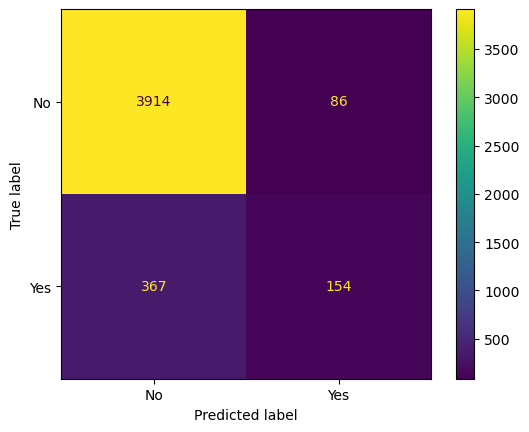

In [40]:
#Import plot confusion matrix function
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(y_test, yhat_lr), display_labels=['No', 'Yes']).plot()

In [41]:
import seaborn as sns
cm_lr = confusion_matrix(y_test, yhat_lr)

<Axes: >

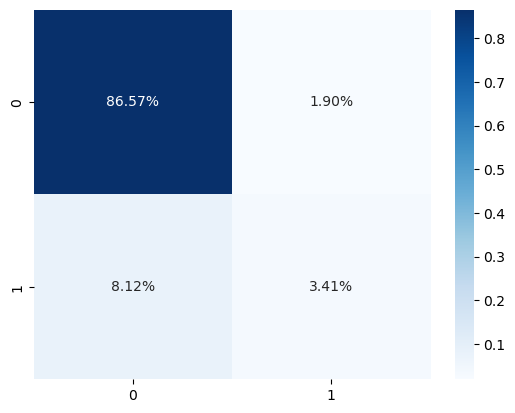

In [42]:
sns.heatmap(cm_lr/np.sum(cm_lr), annot=True, fmt='.2%', cmap='Blues')

In [43]:
print (classification_report(y_test, yhat_lr))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      4000
           1       0.64      0.30      0.40       521

    accuracy                           0.90      4521
   macro avg       0.78      0.64      0.68      4521
weighted avg       0.88      0.90      0.88      4521



# K Nearest Neighbours

In [37]:
x_train.shape

(45211, 31)

In [38]:
K = 10
error_rate = []

for n in range(1,K):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(x_train.values,y_train.values)
    yhat=neigh.predict(x_test.values)
    error_rate.append(1 - accuracy_score(y_test, yhat))

error_rate

[0.0,
 0.0769741207697412,
 0.0756469807564698,
 0.09024552090245519,
 0.08759124087591241,
 0.09356337093563372,
 0.0948905109489051,
 0.09511170095111698,
 0.09643884096438837]

We will select k = 1 as this gives us the highest accuracy and again print classification report

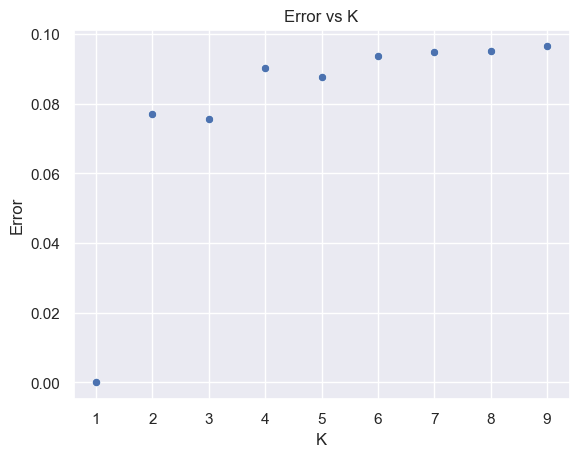

In [39]:
sns.scatterplot(x=range(1,K), y=error_rate)
plt.xlabel('K')
plt.ylabel('Error')
plt.title('Error vs K');

In [40]:
k = 1
Knn = KNeighborsClassifier(n_neighbors=k)
Knn.fit(x_train.values, y_train.values)
yhat_knn = Knn.predict(x_test.values)

<Axes: >

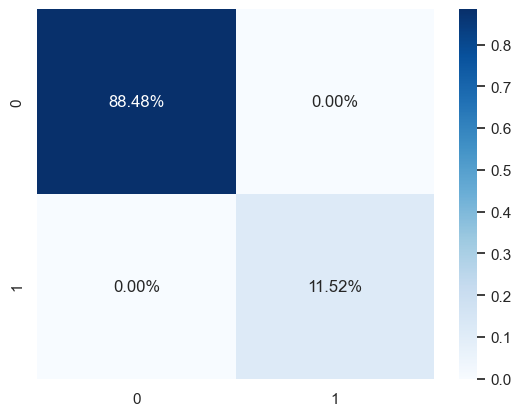

In [41]:
cm_knn = confusion_matrix(y_test, yhat_knn)
sns.heatmap(cm_knn/np.sum(cm_knn), annot=True, cmap='Blues', fmt='.2%')

In [42]:
print (classification_report(y_test, yhat_knn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4000
           1       1.00      1.00      1.00       521

    accuracy                           1.00      4521
   macro avg       1.00      1.00      1.00      4521
weighted avg       1.00      1.00      1.00      4521



We find that KNearestNeighbors is better at classifying the given dataset basis classification report accuracy

# Support Vector Machine

In [54]:
SVM_df = svm.SVC()

In [55]:
parameters_grid_SVC = {'kernel':('linear', 'rbf','poly','sigmoid'),
              'C' : [0.1, 1, 10],
              }

In [56]:
clf = GridSearchCV(SVM_df, parameters_grid_SVC, n_jobs=-1)
clf.fit(x_train, y_train)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10],
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')})

In [ ]:
# clf.best_params_

In [ ]:
# {'C': 0.1, 'kernel': 'linear'} as per clf.best_params_, GridSearchCV takes approx 40 minutes to fit x_train and y_train data
clf_svm = svm.SVC(kernel='linear', C=0.1,probability=True)
clf_svm.fit(x_train, y_train)

In [ ]:
yhat_svm = clf_svm.predict(x_test)

*Checking accuracy*

In [ ]:
# Confusion matrix
cm_svm = confusion_matrix(y_test, yhat_svm)
sns.heatmap(cm_svm / np.sum(cm_svm), cmap = 'Blues', annot = True, fmt='.2%')

In [ ]:
print(classification_report(y_test, yhat_svm))

# Naive Bayes

*Gaussian distribution*

In [45]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB().fit(x_train, y_train)
yhat = clf.predict(x_test)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90      4000
           1       0.35      0.50      0.41       521

    accuracy                           0.83      4521
   macro avg       0.64      0.69      0.66      4521
weighted avg       0.86      0.83      0.85      4521



*Bernoulli Distribution with binarize set to True*

In [46]:
from sklearn.naive_bayes import BernoulliNB
clf_nb = BernoulliNB(binarize=True).fit(x_train, y_train)
yhat_nb = clf_nb.predict(x_test)
print(classification_report(y_test, yhat_nb))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      4000
           1       0.57      0.01      0.02       521

    accuracy                           0.88      4521
   macro avg       0.73      0.50      0.48      4521
weighted avg       0.85      0.88      0.83      4521



<Axes: >

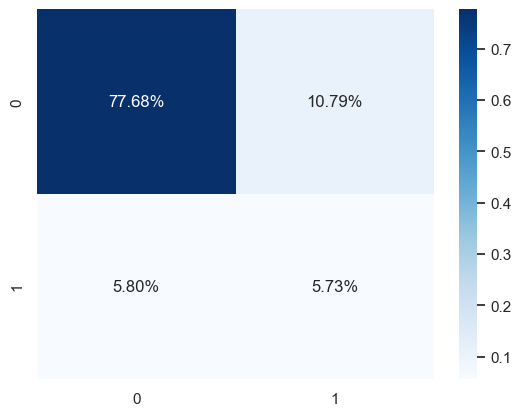

In [47]:
cm_nb = confusion_matrix(y_test,yhat)
sns.heatmap(cm_nb/np.sum(cm_nb), fmt = '.2%', cmap='Blues', annot=True)

# Decision Tree

In [48]:
from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier()
clf_dt.fit(x_train, y_train)
yhat_dt = clf_dt.predict(x_test)
print(classification_report(y_test, yhat_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4000
           1       1.00      1.00      1.00       521

    accuracy                           1.00      4521
   macro avg       1.00      1.00      1.00      4521
weighted avg       1.00      1.00      1.00      4521



<Axes: >

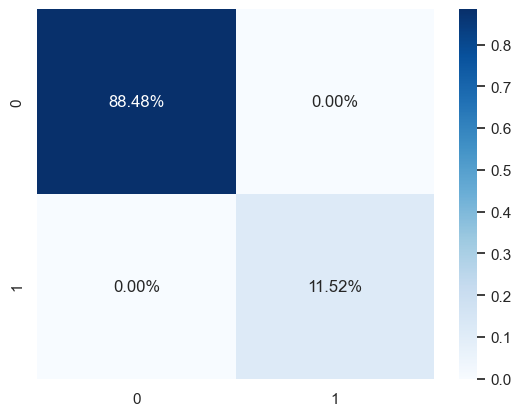

In [49]:
cm_dt = confusion_matrix(y_test, yhat_dt)
sns.heatmap(cm_dt/np.sum(cm_dt), annot=True, fmt = '.2%', cmap='Blues')

*Cost Complexity Pruning*

[Text(0.710072853687206, 0.9838709677419355, 'x[6] <= 521.5\ngini = 0.207\nsamples = 45211\nvalue = [39922, 5289]'),
 Text(0.5125753323482215, 0.9516129032258065, 'x[29] <= 0.5\ngini = 0.142\nsamples = 40238\nvalue = [37132, 3106]'),
 Text(0.35359645424315933, 0.9193548387096774, 'x[6] <= 206.5\ngini = 0.111\nsamples = 38941\nvalue = [36640, 2301]'),
 Text(0.17538677774108738, 0.8870967741935484, 'x[0] <= 60.5\ngini = 0.054\nsamples = 24953\nvalue = [24261, 692]'),
 Text(0.10622240827234672, 0.8548387096774194, 'x[6] <= 129.5\ngini = 0.048\nsamples = 24503\nvalue = [23895, 608]'),
 Text(0.038175880174578895, 0.8225806451612904, 'x[6] <= 77.5\ngini = 0.025\nsamples = 15075\nvalue = [14886, 189]'),
 Text(0.009497657926204635, 0.7903225806451613, 'x[6] <= 60.5\ngini = 0.006\nsamples = 7094\nvalue = [7073, 21]'),
 Text(0.003998082777782999, 0.7580645161290323, 'x[0] <= 29.5\ngini = 0.003\nsamples = 4713\nvalue = [4706, 7]'),
 Text(0.002618213500495061, 0.7258064516129032, 'x[2] <= 9743.0\n

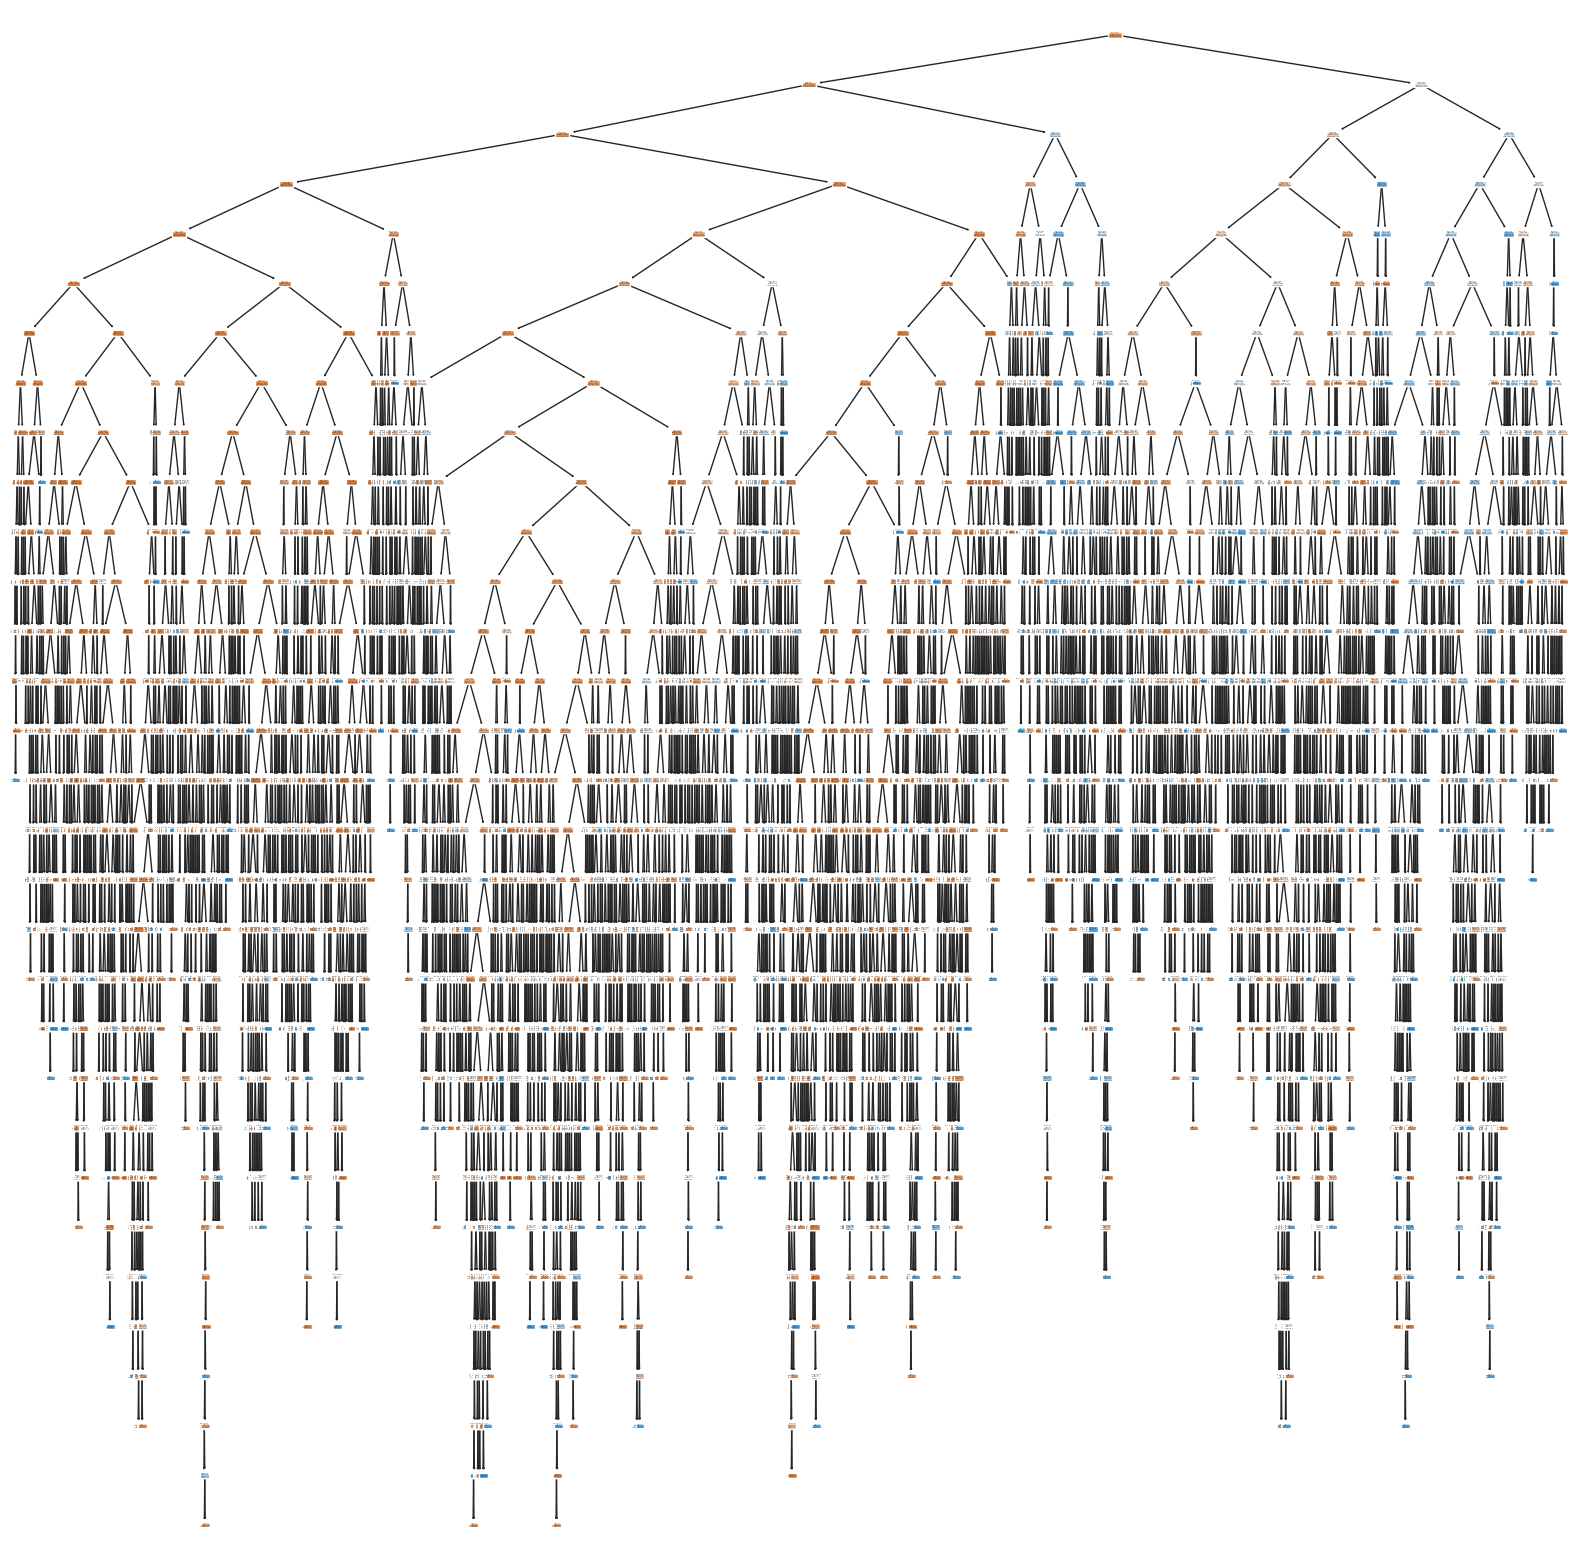

In [50]:
from sklearn import tree
from matplotlib import pyplot as plt
plt.figure(figsize=(20,20))
tree.plot_tree(clf_dt,filled = True)

In [51]:
path = clf_dt.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [52]:
ccp_alphas

array([0.00000000e+00, 8.84138165e-06, 1.09192649e-05, ...,
       3.02159468e-03, 1.75109641e-02, 2.56262503e-02])

In [53]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)

*Accuracy vs Alpha for training & testing sets*

In [ ]:
print (x_train.shape, x_test.shape)

In [ ]:
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")   
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",drawstyle="steps-post")
ax.legend()
plt.show()

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=50, criterion='gini', n_jobs= -1, random_state=42, max_depth=5, min_samples_split=20, min_samples_leaf=10)
clf_rf.fit(x_train, y_train)
yhat_rf = clf.predict(x_test)
cm_rf = confusion_matrix(y_test, yhat_rf)
sns.heatmap(cm_rf/np.sum(cm_rf), annot=True, fmt='0.2%', cmap = 'Blues')

In [ ]:
print(classification_report(y_test, yhat_rf))

# Selecting the best classification algorithm

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

*Calculating ROC curve for Logistic Regression*

In [ ]:
yhat_lr_proba = LR.predict_proba(x_test)[:,1]
print(yhat_lr_proba)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, yhat_lr_proba)
AUC_LR = roc_auc_score(y_test, yhat_lr_proba)
plt.plot(fpr, tpr, linewidth = 4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.show()

In [ ]:
print (AUC_LR*100)

*Calculating ROC curve for SVM*

In [ ]:
yhat_svm_proba = clf_svm.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, yhat_svm_proba)
AUC_SVM = roc_auc_score(y_test, yhat_svm_proba)
plt.plot(fpr, tpr, linewidth = 4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN')
plt.show()

In [ ]:
print(AUC_SVM*100)

*Calculating ROC for Naive Bayes*

In [ ]:
yhat_nb_proba = clf_nb.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, yhat_nb_proba)
AUC_NB = roc_auc_score(y_test, yhat_nb_proba)
plt.plot(fpr, tpr, linewidth = 4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes')
plt.show()
print (AUC_NB*100)

*Calculating ROC for Decision Tree*

In [ ]:
yhat_dt_proba = clf_dt.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, yhat_dt_proba)
AUC_DT = roc_auc_score(y_test, yhat_dt_proba)
plt.plot(fpr, tpr, linewidth = 4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree')
plt.show()
print (AUC_DT*100)

*Calculating ROC for Random Forest*

In [ ]:
yhat_rf_proba = clf_rf.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, yhat_rf_proba)
AUC_RF = roc_auc_score(y_test, yhat_rf_proba)
plt.plot(fpr, tpr, linewidth = 4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.show()
print (AUC_RF*100)

Selected KNN basis best accuracy + greatest area under ROC